# Jax Level 0 Data Scientist Experience - Chapter 1
## Part 1 - New account registration and code execution requests

Link to the original Jax tutorial: https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html

In [1]:
# Import the necessary libraries
import syft as sy
sy.requires(">=0.8-beta")
import jax
import jax.numpy as jnp

/home/teo/anaconda3/envs/PySyft/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/teo/OpenMined/PySyft


✅ The installed version of syft==0.8.0b7 matches the requirement >=0.8b0


In [2]:
# Register a client to the domain
node = sy.orchestra.launch(name="test-domain-1")
guest_domain_client = node.client
guest_domain_client.register(name="Jane Doe", email="jane@caltech.edu", password="abc123", institution="Caltech", website="https://www.caltech.edu/")
guest_domain_client.login(email="jane@caltech.edu", password="abc123")

SQLite Store Path:
!open file:///tmp/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.DataSubjectMemberService'>]


<SyftClient - test-domain-1 <7bca415d13ed1ec841f0d0aede098dbb>: PythonConnection>

In [3]:
# Inspect available data
results = guest_domain_client.api.services.dataset.get_all()
dataset = results[0]
mock = dataset.assets[0].mock
xs = dataset.assets[1]
ys = dataset.assets[2]

In [4]:
# Create a function for code execution
# ATTENTION: ALL LIBRARIES USED SHOULD BE DEFINED INSIDE THE FUNCTION CONTEXT!!!

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func():
    import jax.numpy as jnp
    x = jnp.arange(10)
    return x

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func_timeit():
    import jax.numpy as jnp
    long_vector = jnp.arange(int(1e7))
    %timeit jnp.dot(long_vector, long_vector).block_until_ready()
    
@sy.syft_function(input_policy=sy.ExactMatch(x=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def func_sum_of_squares(x):
    import jax
    import jax.numpy as jnp
    
    def sum_of_squares(x):
        return jnp.sum(x**2)
    sum_of_squares_dx = jax.grad(sum_of_squares)
    return sum_of_squares(x), sum_of_squares_dx(x)

@sy.syft_function(input_policy=sy.ExactMatch(x=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def func_sum_squared_error(x):
    import jax
    import jax.numpy as jnp
    
    def sum_squared_error(x, y):
        return jnp.sum((x-y)**2)
    sum_squared_error_dx = jax.grad(sum_squared_error)
    y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
    return sum_squared_error_dx(x, y), jax.grad(sum_squared_error, argnums=(0, 1))(x, y)


@sy.syft_function(input_policy=sy.ExactMatch(x=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def func_sum_squared_error_with_aux(x):
    import jax
    import jax.numpy as jnp
    
    def sum_squared_error(x, y):
        return jnp.sum((x-y)**2)
    
    def squared_error_with_aux(x, y):
        return sum_squared_error(x, y), x-y

    y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
    return jax.grad(squared_error_with_aux, has_aux=True)(x, y)


@sy.syft_function(input_policy=sy.ExactMatch(x=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def func_naive_modify(x):
    import jax
    import jax.numpy as jnp
    def in_place_modify(x):
        x[0] = 123
        return None

    try:
        in_place_modify(jnp.array(x))
    except Exception as e:
        print(e)


@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func_jax_modify():
    import jax
    import jax.numpy as jnp
    def jax_in_place_modify(x):
        return x.at[0].set(123)

    y = jnp.array([1, 2, 3])
    return jax_in_place_modify(y)

@sy.syft_function(input_policy=sy.ExactMatch(xs=xs.mock, ys=ys.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def training_loop(xs, ys):
    import jax
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    
    def model(theta, x):
        """Computes wx + b on a batch of input x."""
        w, b = theta
        return w * x + b
    
    def loss_fn(theta, x, y):
        prediction = model(theta, x)
        return jnp.mean((prediction-y)**2)
    
    def update(theta, x, y, lr=0.1):
        return theta - lr * jax.grad(loss_fn)(theta, x, y)

    theta = jnp.array([1., 1.])

    for _ in range(1000):
        theta = update(theta, xs, ys)

    plt.scatter(xs, ys)
    plt.plot(xs, model(theta, xs))

    w, b = theta
    print(f"w: {w:<.2f}, b: {b:<.2f}")
    return w, b


[0 1 2 3 4 5 6 7 8 9]
4.39 ms ± 70.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
(DeviceArray(4., dtype=float64), DeviceArray([2., 2., 2., 2.], dtype=float64))
w: 3.00, b: -1.00
(DeviceArray(3.00182483, dtype=float64), DeviceArray(-1.00017478, dtype=float64))


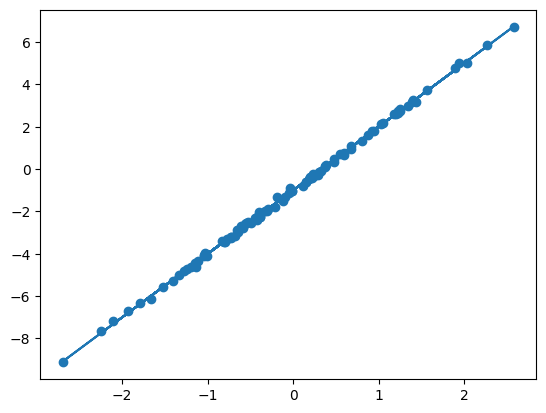

In [5]:
# Test our function locally 
print(func())
print(func_timeit())
print(func_sum_of_squares(x=mock))
print(training_loop(xs=xs.mock, ys=ys.mock))

In [6]:
# Submit the function for code execution
# guest_domain_client.api.services.code.request_code_execution(func)
# guest_domain_client.api.services.code.request_code_execution(func_timeit)
# guest_domain_client.api.services.code.request_code_execution(func_sum_of_squares)
# guest_domain_client.api.services.code.request_code_execution(func_sum_squared_error)
# guest_domain_client.api.services.code.request_code_execution(func_sum_squared_error_with_aux)
# guest_domain_client.api.services.code.request_code_execution(func_naive_modify)
# guest_domain_client.api.services.code.request_code_execution(func_jax_modify)
guest_domain_client.api.services.code.request_code_execution(training_loop)

syft.core.node.new.user_code.SubmitUserCode
Ok(syft.core.node.new.user_code.UserCode)


```python
class Request:
  id: str = 03298d54031d40b3a52458a5c8adeaa8
  requesting_user_verify_key: str = 698f28b732485ddc742194c57a44ddc7b547d3bf4447d62321803ea97092f7d0
  approving_user_verify_key: str = None
  request_time: str = 2023-04-17 06:22:21
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 7bca415d13ed1ec841f0d0aede098dbb
  request_hash: str = "4a660e2ee6530cd91667042853c90c810376934e6034b8c8c7b2067af13196cf"
  changes: str = [syft.core.node.new.request.UserCodeStatusChange]

```

In [7]:
# new_project = sy.Project(name="My Cool Jax Project")
# proj_desc = """Hi, I want to learn Jax and PySyft"""
# new_project.set_description(proj_desc)
# for code_obj in guest_domain_client.code:
#     new_project.add_request(obj=code_obj, permission=sy.UserCodeStatus.EXECUTE)

In [8]:
# guest_domain_client.submit_project(new_project)

In [9]:
# guest_domain_client._api = None
# _ = guest_domain_client.api

In [10]:
guest_domain_client.api.services.code.training_loop()

<class 'syft.core.node.new.response.SyftNotReady'>: <class 'syft.core.node.new.user_code.UserCode'> Your code is waiting for approval: {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}

### Go to the Data Owner Notebook for Part 2!

## Part 3 - Downloading the Results

In [ ]:
result = guest_domain_client.api.services.code.training_loop()

In [ ]:
result.get_result()